<a href="https://colab.research.google.com/github/mohd-raza/Learning-Tensorflow/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:

* Can leverage an existing neural network architecture proven to work on problems similar to our own.
* Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

In [ ]:
# Are we using a GPU?
!nvidia-smi

Sun Jul 17 15:04:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Get data 10% of 10 food classes
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-07-17 15:04:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   125MB/s    in 1.3s    

2022-07-17 15:04:24 (125 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' ")

There are 2 directories and 0 images in '10_food_classes_10_percent' 
There are 10 directories and 0 images in '10_food_classes_10_percent/test' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen' 
There are 0 directories and 250 images in '10_food_classes_10_percent

##Creating data loaders (preparing the data)
We'll use the ImageDataGenerator class to load in our images in batches.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir, 
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training Images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# create Tensorboard callback functionized bcz we need to create a new one for each
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard files to {log_dir}")
  return tensorboard_callback

#Creating models using TensorFlow Hub
In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majroity of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# let's make a create_model () to create model from a URL
def create_model(model_url,num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  feature_extractor_layer = hub.KerasLayer(model_url,trainable=False,
                                          name="feature_extraction_layer",
                                          input_shape = IMAGE_SHAPE + (3,)) # freeze the already learned patterns
  # create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])
  return model

#### Creating and testing our ResNet Model

In [ ]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving Tensorboard files to tensorflow_hub/resnet50V2/20220717-150442
Epoch 1/5
24/24 [==============================] - 33s 738ms/step - loss: 2.0213 - accuracy: 0.3533 - val_loss: 1.2743 - val_accuracy: 0.5828
Epoch 2/5
24/24 [==============================] - 15s 664ms/step - loss: 0.9334 - accuracy: 0.7173 - val_loss: 0.8596 - val_accuracy: 0.7312
Epoch 3/5
24/24 [==============================] - 15s 660ms/step - loss: 0.6314 - accuracy: 0.8147 - val_loss: 0.7660 - val_accuracy: 0.7452
Epoch 4/5
24/24 [==============================] - 17s 720ms/step - loss: 0.4962 - accuracy: 0.8733 - val_loss: 0.6991 - val_accuracy: 0.7764
Epoch 5/5
24/24 [==============================] - 15s 660ms/step - loss: 0.3857 - accuracy: 0.9080 - val_loss: 0.6874 - val_accuracy: 0.7768


In [ ]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))
  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

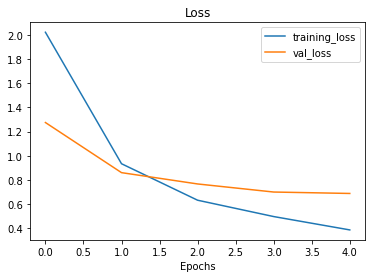

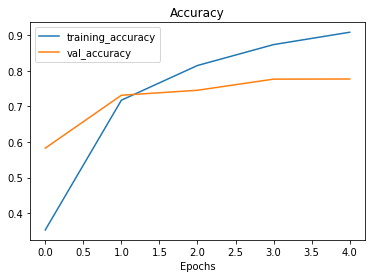

In [ ]:
plot_loss_curves(resnet_history)

#Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving Tensorboard files to tensorflow_hub/efficientnetb0/20220717-150636
Epoch 1/5
24/24 [==============================] - 25s 698ms/step - loss: 1.8937 - accuracy: 0.4080 - val_loss: 1.3445 - val_accuracy: 0.7380
Epoch 2/5
24/24 [==============================] - 15s 633ms/step - loss: 1.0597 - accuracy: 0.7907 - val_loss: 0.8760 - val_accuracy: 0.8172
Epoch 3/5
24/24 [==============================] - 15s 640ms/step - loss: 0.7430 - accuracy: 0.8480 - val_loss: 0.6980 - val_accuracy: 0.8468
Epoch 4/5
24/24 [==============================] - 15s 636ms/step - loss: 0.5951 - accuracy: 0.8720 - val_loss: 0.6121 - val_accuracy: 0.8552
Epoch 5/5
24/24 [==============================] - 15s 637ms/step - loss: 0.5035 - accuracy: 0.8987 - val_loss: 0.5598 - val_accuracy: 0.8632


In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


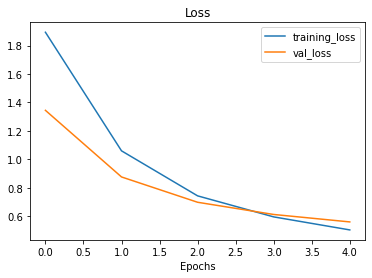

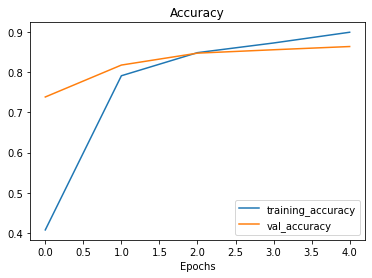

In [ ]:
plot_loss_curves(efficientnet_history)

# Different types of transfer learning
* "As is" transfer learning - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* "Feature extraction" transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* "Fine-tuning" transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

In [ ]:
len(efficientnet_model.layers[0].weights)

309

##Comparing our models results using TensorBoard


In [ ]:
# upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=fJIbyLH16KN85wTguVwtfhrhydJP3K&prompt=consent&access_type=off

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/UKhPb6rPSLqOvwygAjvF9w/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   UKhPb6rPSLqOvwygAjvF9w
	Created              2022-07-17 15:24:34 (1 minute ago)
	Updated              2022-07-17 15:24:39 (1 minute ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918538
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id dQBrpdwIRgS2qI0Andv8Yg